# H2O Uplift Distributed Random Forest 

## How difference in threatment group affect prediction


## Start H2O-3

In [1]:
import sys
sys.path.append("../build/main")

import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd

versionFromGradle='3.36.1',projectVersion='3.36.1.99999',branch='rel-zumbo',lastCommitHash='673f3fa5fc3c3e8f7e8b797db61e6488fe56f7e1',gitDescribe='jenkins-3.36.1.3-13-g673f3fa5fc-dirty',compiledOn='2022-07-26 01:46:40',compiledBy='adam'


In [2]:
h2o.init(strict_version_check=False, max_mem_size=10)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_311"; Java(TM) SE Runtime Environment (build 1.8.0_311-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from /Users/adam/h2o-3/build/h2o.jar
  Ice root: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpd9vuca31
  JVM stdout: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpd9vuca31/h2o_adam_started_from_python.out
  JVM stderr: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpd9vuca31/h2o_adam_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_adam_wbwyq6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Load data

To demonstrate how Uplift DRF works, Criteo dataset is used. 

**Source:**

Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini, "A Large Scale Benchmark for Uplift Modeling", ACM, Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018, https://ailab.criteo.com/criteo-uplift-prediction-dataset/.



**Description:**

- The dataset was created by The Criteo AI Lab
- Consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions).
- Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks).
- The global treatment ratio is 84.6%.

**Detailed description of the columns:**

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)
- **treatment**: treatment group (1 = treated, 0 = control)
- **conversion**: whether a conversion occured for this user (binary, label)
- **visit**: whether a visit occured for this user (binary, label)
- **exposure**: treatment effect, whether the user has been effectively exposed (binary)

In [3]:
control_name = "control"
treatment_column = "treatment"
response_column = "visit"
feature_cols = ["f"+str(x) for x in range(0,12)]

df = pd.read_csv("../../bigdata/laptop/criteo-uplift-v2.1.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Prepare data

Inspiration from: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

To modeling uplift the treatment and control group data have to have similar distribution. In real world usually the control group is smaller than the treatment group. It is also a case of Crieteo dataset and we have to rebalanced the data to have a similar size.

In [4]:
print('Total number of samples: {}'.format(len(df)))
print('The dataset is largely imbalanced: ')
print(df['treatment'].value_counts(normalize = True))
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Total number of samples: 13979592
The dataset is largely imbalanced: 
1    0.85
0    0.15
Name: treatment, dtype: float64
Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


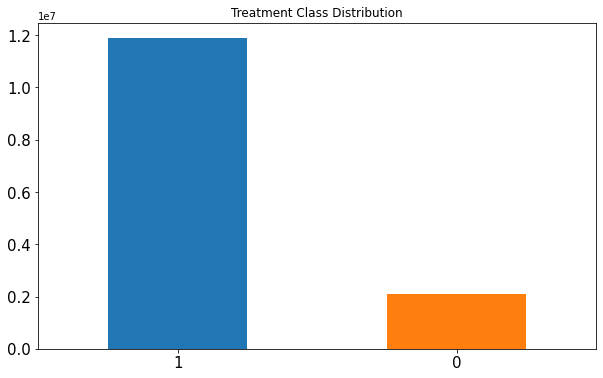

In [5]:
# Print proportion of a binary column
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def print_proportion(df, column):
    fig = plt.figure(figsize = (10,6))
    target_count = df[column].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
    target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
    plt.xticks(rotation=0) 
    
print_proportion(df, treatment_column)

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])
print(train_df.shape)
print(test_df.shape)

(11183673, 16)
(2795919, 16)


In [7]:
del(df)

Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1


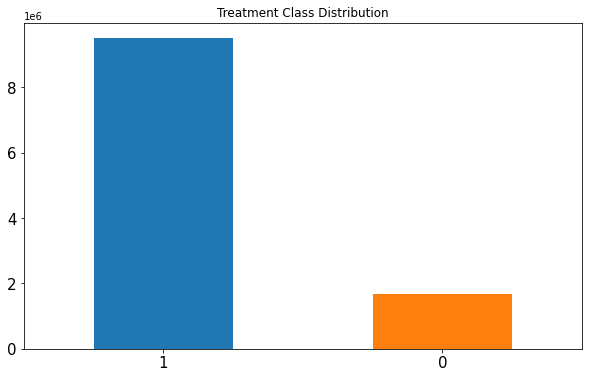

In [8]:
print_proportion(train_df, treatment_column)

In [9]:
# Random Undersampling (finding the majority class and undersampling it)
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def random_under(df, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [10]:
train_df_orig = train_df.copy()
train_df = random_under(train_df, treatment_column)

Original
Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1
Balanced
Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


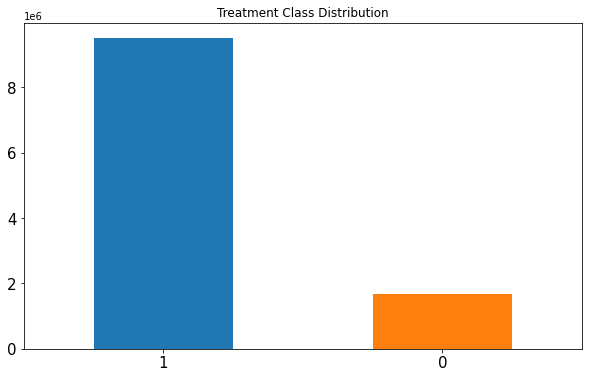

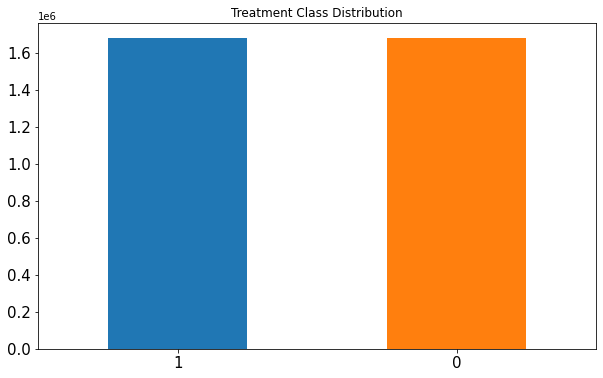

In [11]:
print("Original")
print_proportion(train_df_orig, treatment_column)
print("Balanced")
print_proportion(train_df, treatment_column)

## Import data to H2O

In [12]:
h2o_test_df = h2o.H2OFrame(destination_frame="uplift_criteo_test", python_obj=test_df)

h2o_test_df[treatment_column] = h2o_test_df[treatment_column].asfactor()
h2o_test_df[response_column] = h2o_test_df[response_column].asfactor()
del(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
h2o_train_df_balanced = h2o.H2OFrame(python_obj=train_df)

h2o_train_df_balanced[treatment_column] = h2o_train_df_balanced[treatment_column].asfactor()
h2o_train_df_balanced[response_column] = h2o_train_df_balanced[response_column].asfactor()

del(train_df)

In [15]:
h2o_train_df_orig = h2o.H2OFrame(python_obj=train_df_orig)

h2o_train_df_orig[treatment_column] = h2o_train_df_orig[treatment_column].asfactor()
h2o_train_df_orig[response_column] = h2o_train_df_orig[response_column].asfactor()

del(train_df_orig)

h2o.ls()

H2OConnectionError: Unexpected HTTP error: ('Connection aborted.', OSError(22, 'Invalid argument'))

## Train H2O UpliftDRF model

In [ ]:
ntree = 20
max_depth = 15
metric="Euclidean"

h2o_uplift_model = H2OUpliftRandomForestEstimator(model_id="uplift_balanced"
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="gain",
                    seed=42)

h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=h2o_train_df_balanced)
h2o_uplift_model

## Predict and plot Uplift Score

In [ ]:
h2o_uplift_pred = h2o_uplift_model.predict(h2o_test_df)
h2o_uplift_pred

In [ ]:
perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)

In [ ]:
perf_h2o.auuc_table()

### Cumulative Uplift curve plot

To plot the uplift curve, the ``plot_uplift``method can be used. There is specific parameter ``metric`` which can be ``"qini", "gain", or "lift"``. The most popular is the Qini uplift curve which is similar to the ROC curve. The Gain and Lift curves are also known from traditional binomial models. 

Depending on these curves, you can decide how many observations (for example customers) from the test dataset you send an offer to get optimal gain.

In [ ]:
perf_h2o.plot_uplift(metric="qini")

In [ ]:
def train_uplift(metric):
    ntree = 20
    max_depth = 15

    h2o_uplift_model_orig = H2OUpliftRandomForestEstimator(model_id="uplift_orig"
                        ntrees=ntree,
                        max_depth=max_depth,
                        min_rows=30,
                        nbins=1000,
                        sample_rate=0.80,
                        score_each_iteration=True,
                        treatment_column=treatment_column,
                        uplift_metric=metric,
                        auuc_nbins=1000,
                        auuc_type="gain",
                        seed=42)

    h2o_uplift_model_orig.train(y=response_column, x=feature_cols, training_frame=h2o_train_df_orig)
    display(h2o_uplift_model_orig)
    perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)
    display(perf_h2o.auuc_table())
    display(perf_h2o.plot_uplift(metric="qini"))

In [ ]:
train_uplift("euclidean")

In [ ]:
train_uplift("kl")

In [ ]:
train_uplift("chi_squared")